# transforms

> Some custom Torchvision tranforms.

In [ ]:
#| default_exp transforms

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import sys
from typing import Any, Dict, Optional, List, Tuple, Union
import random
from functools import singledispatchmethod

from cjm_pil_utils.core import stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil

import numpy as np

from PIL import Image, ImageFilter, ImageEnhance

# Import PyTorch dependencies
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

from torchvision.transforms.v2._utils import query_size, get_bounding_boxes
from torchvision.ops.boxes import box_iou
from torchvision.ops import box_convert
from torchvision.tv_tensors import BoundingBoxFormat
from torchvision.tv_tensors import wrap as tv_wrap
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2.functional import InterpolationMode

import random
import numpy as np
import cv2
import torch
from torchvision.tv_tensors import BoundingBoxes, Mask, Image as TVImage
from torchvision.transforms.v2 import functional as F
from PIL import Image

cv2.setNumThreads(1)

Image Dims: (384, 512)


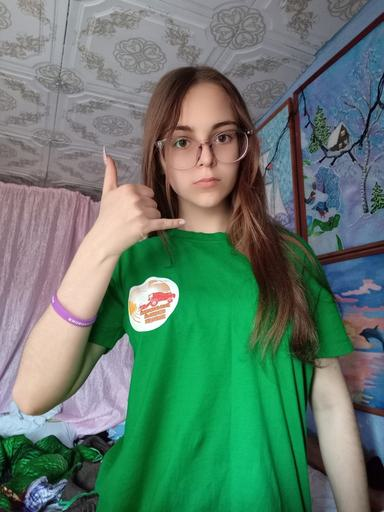

In [ ]:
img_path = './images/call-hand-gesture.png'

# Open the associated image file as a RGB image
sample_img = Image.open(img_path).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

In [ ]:
#| export
class ResizeMax(transforms.Transform):
    """
    A PyTorch Transform class that resizes an image such that the maximum dimension 
    is equal to a specified size while maintaining the aspect ratio.
    """
    
    def __init__(self, 
                 max_sz:int=256 # The maximum size for any dimension (height or width) of the image.
                ):
        """
        Initialize ResizeMax object with a specified max_sz. 
        """
        # Call to the parent class (Transform) constructor
        super().__init__()

        # Set the maximum size for any dimension of the image
        self.max_sz = max_sz
        
    def _transform(self, 
                   inpt: Any, # The input image tensor to be resized.
                   params: Dict[str, Any] # A dictionary of parameters. Not used in this method but is present for compatibility with the parent's method signature.
                  ) -> torch.Tensor: # The resized image tensor.
        """
        Apply the ResizeMax transformation on an input image tensor.
        """

        # Copy the input tensor to a new variable
        x = inpt

        # Get the width and height of the image tensor
        spatial_size = TF.get_size(x)

        # Calculate the size for the smaller dimension, such that the aspect ratio 
        # of the image is maintained when the larger dimension is resized to max_sz
        size = int(min(spatial_size) / (max(spatial_size) / self.max_sz))

        # Resize the image tensor with antialiasing for smoother output
        x = TF.resize(x, size=size, antialias=True)

        # Return the transformed (resized) image tensor
        return x

In [ ]:
target_sz = 384

Source image: (384, 512)
Image tensor: torch.Size([1, 3, 512, 384])
Padded tensor: torch.Size([1, 3, 384, 288])


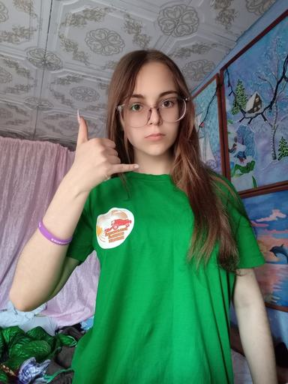

In [ ]:
print(f"Source image: {sample_img.size}")

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=target_sz)

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)[None]
print(f"Image tensor: {img_tensor.shape}")

# Resize the tensor
resized_tensor = resize_max(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Display the updated image
tensor_to_pil(resized_tensor)

In [ ]:
#| export
class PadSquare(transforms.Transform):
    """
    PadSquare is a PyTorch Transform class used to pad images to make them square. 
    Depending on the configuration, padding can be applied equally on both sides, 
    or can be randomly split between the two sides.
    """

    def __init__(self, 
                 padding_mode:str='constant', # The method to use for padding. Default is 'constant'.
                 fill:tuple=(123, 117, 104), # The RGB values to use for padding if padding_mode is 'constant'.
                 shift:bool=True # If True, padding is randomly split between the two sides. If False, padding is equally applied.
                ):
        """
        The constructor for PadSquare class.
        """
        super().__init__()
        self.padding_mode = padding_mode
        self.fill = fill
        self.shift = shift
        self.pad_split = None

    def forward(self, 
                *inputs: Any # The inputs to the forward method.
               ) -> Any: # The result of the superclass forward method.
        """
        The forward method that sets up the padding split factor if 'shift' is True, 
        and then calls the superclass forward method.
        """
        self.pad_split = random.random() if self.shift else None
        return super().forward(*inputs)

    def _transform(self, 
                   inpt: Any, # The input to be transformed.
                   params: Dict[str, Any] # A dictionary of parameters for the transformation.
                  ) -> Any: # The transformed input.
        """
        The _transform method that applies padding to the input to make it square.
        """
        x = inpt
        
        # Get the width and height of the image tensor
        h, w = TF.get_size(x)
        
        # If shift is true, padding is randomly split between two sides
        if self.shift:
            offset = (max(w, h) - min(w, h))
            pad_1 = int(offset*self.pad_split)
            pad_2 = offset - pad_1
            
            # The padding is applied to the shorter dimension of the image
            self.padding = [0, pad_1, 0, pad_2] if h < w else [pad_1, 0, pad_2, 0]
            padding = self.padding
        else:
            # If shift is false, padding is equally split between two sides
            offset = (max(w, h) - min(w, h)) // 2
            padding = [0, offset] if h < w else [offset, 0]
        
        # Apply the padding to the image
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode, fill=self.fill)
        
        return x

Resized tensor: torch.Size([3, 384, 288])
Padded tensor: torch.Size([3, 384, 384])


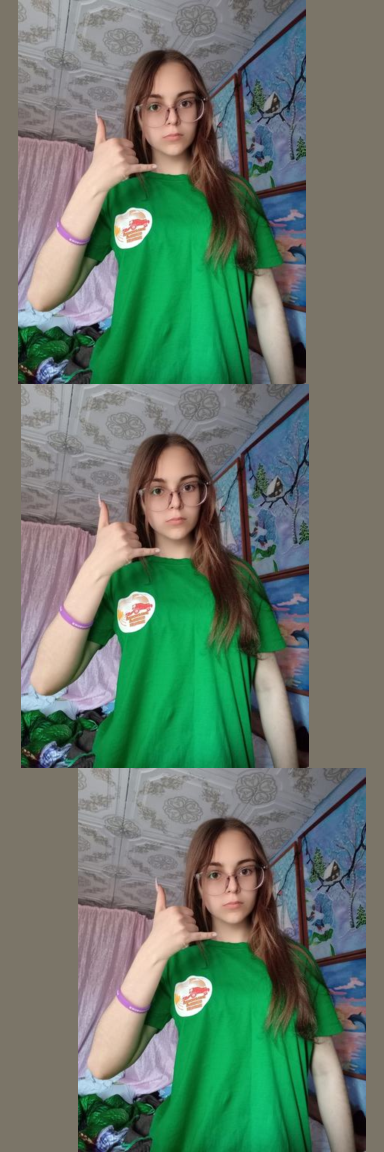

In [ ]:
print(f"Resized tensor: {resized_tensor.shape}")

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

# Pad the tensor
padded_tensor = pad_square(resized_tensor)
print(f"Padded tensor: {padded_tensor.shape}")

# Display the updated image
stack_imgs([tensor_to_pil(pad_square(resized_tensor)) for i in range(3)])

In [ ]:
#| export

class CustomTrivialAugmentWide(torchvision.transforms.TrivialAugmentWide):
    """
    This class extends the TrivialAugmentWide class provided by PyTorch's transforms module.
    TrivialAugmentWide is an augmentation policy randomly applies a single augmentation to each image.
    """
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: transforms.InterpolationMode = transforms.InterpolationMode.NEAREST,
        fill: Optional[List[float]] = None,
        op_meta: Optional[Dict[str, Tuple[torch.Tensor, bool]]] = None
    ) -> None:
        super().__init__(num_magnitude_bins, interpolation, fill)
        self.op_meta = op_meta if op_meta else super()._augmentation_space(num_magnitude_bins)

    def _augmentation_space(self, 
                            num_bins: int
                           ) -> Dict[str, Tuple[torch.Tensor, bool]]:
        return self.op_meta

In [ ]:
num_bins = 31

custom_augmentation_space = {
    # Identity operation doesn't change the image
    "Identity": (torch.tensor(0.0), False),
            
    # Distort the image along the x or y axis, respectively.
    "ShearX": (torch.linspace(0.0, 0.25, num_bins), True),
    "ShearY": (torch.linspace(0.0, 0.25, num_bins), True),

    # Move the image along the x or y axis, respectively.
    "TranslateX": (torch.linspace(0.0, 32.0, num_bins), True),
    "TranslateY": (torch.linspace(0.0, 32.0, num_bins), True),

    # Rotate operation: rotates the image.
    "Rotate": (torch.linspace(0.0, 45.0, num_bins), True),

    # Adjust brightness, color, contrast,and sharpness respectively.
    "Brightness": (torch.linspace(0.0, 0.75, num_bins), True),
    "Color": (torch.linspace(0.0, 0.99, num_bins), True),
    "Contrast": (torch.linspace(0.0, 0.99, num_bins), True),
    "Sharpness": (torch.linspace(0.0, 0.99, num_bins), True),

    # Reduce the number of bits used to express the color in each channel of the image.
    "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 6)).round().int(), False),

    # Invert all pixel values above a threshold.
    "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),

    # Maximize the image contrast by setting the darkest color to black and the lightest to white.
    "AutoContrast": (torch.tensor(0.0), False),

    # Equalize the image histogram to improve its contrast.
    "Equalize": (torch.tensor(0.0), False),
}

Augmented tensor: torch.Size([3, 384, 288])


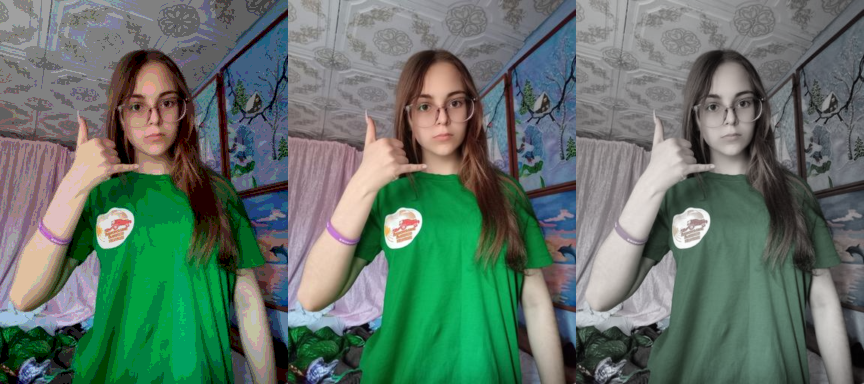

In [ ]:
# Create a `CustomTrivialAugmentWide` object
trivial_aug = CustomTrivialAugmentWide(op_meta=custom_augmentation_space)

# Pad the tensor
aug_tensor = trivial_aug(resized_tensor)
print(f"Augmented tensor: {aug_tensor.shape}")

# Display the updated image
stack_imgs([tensor_to_pil(trivial_aug(resized_tensor)) for i in range(3)])

In [ ]:
#| export
class CustomRandomIoUCrop(transforms.RandomIoUCrop):
    """
    A customized Random IoU crop transformation that inherits from torchvision's RandomIoUCrop transform.
    """
    
    def __init__(
        self,
        min_scale: float = 0.3, # Minimum factors to scale the input size.
        max_scale: float = 1.0, # Maximum factors to scale the input size.
        min_aspect_ratio: float = 0.5, # Minimum aspect ratio for the cropped image or video.
        max_aspect_ratio: float = 2.0, # Maximum aspect ratio for the cropped image or video.
        sampler_options: Optional[List[float]] = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], # List of minimal IoU (Jaccard) overlap between all the boxes a cropped image or video.
        trials: int = 40, # Number of trials to find a crop for a given value of minimal IoU (Jaccard) overlap.
        jitter_factor: float = 0.0 # Value to jitter the center coordinates for the crop area.
    ):
        super().__init__(min_scale, max_scale, min_aspect_ratio, max_aspect_ratio, sampler_options, trials)
        self.jitter_factor = jitter_factor
    
    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        orig_h, orig_w = query_size(flat_inputs)
        bboxes = get_bounding_boxes(flat_inputs)
        
        bbox_dims = bboxes[...,2:]

        # Get all bbox centers
        xyxy_bboxes_orig = box_convert(
            bboxes.as_subclass(torch.Tensor), bboxes.format.value.lower(), torchvision.tv_tensors.BoundingBoxFormat.XYXY.value.lower()
        )

        cx = 0.5 * (xyxy_bboxes_orig[..., 0] + xyxy_bboxes_orig[..., 2])
        cy = 0.5 * (xyxy_bboxes_orig[..., 1] + xyxy_bboxes_orig[..., 3])
        
        for _ in range(self.trials):
            # Sample an option
            idx = int(torch.randint(low=0, high=len(self.options), size=(1,)))
            min_jaccard_overlap = self.options[idx]
            if min_jaccard_overlap >= 1.0:
                return dict()

            # Check aspect ratio limitations and generate new width and height
            while True:
                r = self.min_scale + (self.max_scale - self.min_scale) * torch.rand(2)
                new_w = int(orig_w * r[0])
                new_h = int(orig_h * r[1])
                aspect_ratio = new_w / new_h
                if self.min_aspect_ratio <= aspect_ratio <= self.max_aspect_ratio:
                    break

            # Bounding Box Guided Sampling
            center_idx = torch.randint(low=0, high=cx.shape[0], size=(1,))
            crop_center_x = cx[center_idx]
            crop_center_y = cy[center_idx]
            
            # Add jitter to the crop centers
            jitter_val_x = self.jitter_factor * bbox_dims[center_idx.item()][0].item() * torch.randn(1).to(crop_center_x.device)
            jitter_val_y = self.jitter_factor * bbox_dims[center_idx.item()][1].item() * torch.randn(1).to(crop_center_y.device)

            crop_center_x += jitter_val_x
            crop_center_y += jitter_val_y

            left = int(crop_center_x - new_w / 2)
            top = int(crop_center_y - new_h / 2)
            right = left + new_w
            bottom = top + new_h

            # Adjust if out of bounds
            if left < 0: left, right = 0, new_w
            if right > orig_w: right, left = orig_w, orig_w - new_w
            if top < 0: top, bottom = 0, new_h
            if bottom > orig_h: bottom, top = orig_h, orig_h - new_h

            is_within_crop_area = (left < cx) & (cx < right) & (top < cy) & (cy < bottom)
            if not is_within_crop_area.any():
                continue

            # Check at least 1 box with jaccard limitations
            xyxy_bboxes = xyxy_bboxes_orig[is_within_crop_area]
            ious = box_iou(
                xyxy_bboxes,
                torch.tensor([[left, top, right, bottom]], dtype=xyxy_bboxes.dtype, device=xyxy_bboxes.device),
            )
                        
            if ious.max() < min_jaccard_overlap:
                continue
            
            return dict(top=top, 
                        left=left, 
                        height=new_h, 
                        width=new_w, 
                        is_within_crop_area=is_within_crop_area)
        return dict()

In [ ]:
class_names = ['call']

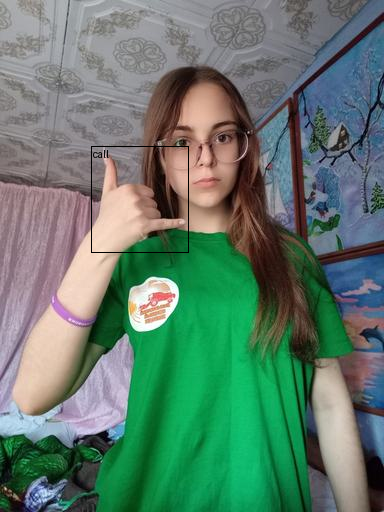

In [ ]:
# Prepare bounding box targets
targets = {
    'boxes': BoundingBoxes([[ 91.8727, 146.4079, 188.0844, 252.7894]], 
                         format=BoundingBoxFormat.XYXY, 
                         canvas_size=sample_img.size[::-1]),
    'labels': torch.Tensor([class_names.index(label) for label in ['call']])
}
# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']],
)

display(tensor_to_pil(annotated_tensor))

In [ ]:
#| hide
torch.manual_seed(1);

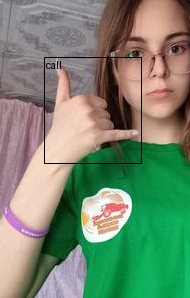

In [ ]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                                  max_scale=1.0, 
                                  min_aspect_ratio=0.5, 
                                  max_aspect_ratio=2.0, 
                                  sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                                  trials=400, 
                                  jitter_factor=0.25)

# Crop the image
cropped_img, cropped_targets = iou_crop(sample_img, targets)
sanitized_img, sanitized_targets = transforms.SanitizeBoundingBoxes()(cropped_img, cropped_targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(sanitized_img), 
    boxes=cropped_targets['boxes'], 
    labels=[class_names[int(label.item())] for label in sanitized_targets['labels']],
)

tensor_to_pil(annotated_tensor)

In [ ]:
#| export
class RandomPatchCopy(transforms.Transform):
    """
    A torchvision V2 transform that copies data from a randomly selected rectangular patch
    to another randomly selected rectangular region of an image tensor multiple times.
    """
    def __init__(self, 
                 pct:float=0.2, # The percentage of the tensor's size to be used as the side length of the square regions.
                 min_num:int=0, # The minimum number of times to apply the `rand_square_copy` function.
                 max_num:int=4, # The maximum number of times to apply the `rand_square_copy` function.
                 iou_thresh:float=0.25 # The IoU threshold for bounding box suppression.
                ):
        
        super().__init__()
        self.pct = pct
        self.min_num = min_num
        self.max_num = max_num
        self.iou_thresh = iou_thresh
        self.patches = []


    def calculate_iou_multi(self,
                            boxes1:torch.Tensor, # An array of bounding boxes in [x1, y1, x2, y2] format.
                            boxes2:torch.Tensor # Another array of bounding boxes in [x1, y1, x2, y2] format.
                           ) -> torch.Tensor: # A 2D array where element (i, j) is the IoU of boxes1[i] and boxes2[j].
        """
        Calculate the Intersection over Union (IoU) for each combination of bounding boxes in two arrays
        using PyTorch broadcasting.
        """
        # Expand boxes1 and boxes2 for broadcasting
        boxes1 = boxes1[:, None, :]
        boxes2 = boxes2[None, :, :]
    
        # Calculate intersection coordinates
        int_x1 = torch.max(boxes1[..., 0], boxes2[..., 0])
        int_y1 = torch.max(boxes1[..., 1], boxes2[..., 1])
        int_x2 = torch.min(boxes1[..., 2], boxes2[..., 2])
        int_y2 = torch.min(boxes1[..., 3], boxes2[..., 3])
    
        # Calculate intersection and union areas
        int_area = torch.clamp(int_x2 - int_x1, min=0) * torch.clamp(int_y2 - int_y1, min=0)
        box1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
        box2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])
        union_area = box1_area + box2_area - int_area
    
        # Calculate IoU
        iou = int_area / torch.clamp(union_area, min=1e-10)
    
        return iou
    

    def rand_patch_copy(self, 
                        img_tensor:torch.Tensor, # The input image tensor.
                        pct:float # # The percentage of the image tensor's size to be used as the side length of the patch.
                       ) -> (torch.Tensor, tuple): # The modified input image tensor and coordinates of the target patch in the format [x, y, w, h].
        """
        Copy data from a randomly selected rectangular patch to another randomly selected 
        rectangular region of an image tensor, and return the coordinates of the target patch.
        Assumes the tensor is in 'channels-first' format.
        """
        if not (0 < pct <= 1):
            raise ValueError("pct must be between 0 and 1")
    
        # Get the shape of the tensor
        _, h, w = img_tensor.shape
    
        # Calculate the size of the rectangle
        szx = int(pct * w)
        szy = int(pct * h)
    
        # Calculate the top-left coordinate of the source rectangle
        sty1 = random.randint(0, w - szx)  # x-coordinate
        stx1 = random.randint(0, h - szy)  # y-coordinate
    
        # Calculate the top-left coordinate of the target rectangle
        sty2 = random.randint(0, w - szx)  # x-coordinate
        stx2 = random.randint(0, h - szy)  # y-coordinate
    
        # Copy the data from the source square to the target rectangle
        img_tensor[:, stx2:stx2 + szy, sty2:sty2 + szx] = img_tensor[:, stx1:stx1 + szy, sty1:sty1 + szx]
    
        # The coordinates of the target patch
        target_patch_coords = [sty2, stx2, sty2 + szx, stx2 + szy]
    
        return img_tensor, target_patch_coords


    @singledispatchmethod
    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        """Default Behavior: Don't modify the input"""
        return inpt

    @_transform.register(torch.Tensor)
    @_transform.register(tv_tensors.Image)
    def _(self, inpt: Union[torch.Tensor, tv_tensors.Image], params: Dict[str, Any]) -> Any:
        self.patches = []
        """Apply the `rand_square_copy` function to the input tensor multiple times"""
        for i in range(random.randint(self.min_num, self.max_num)):
            inpt, patch = self.rand_patch_copy(inpt, max(0.1,random.random()*self.pct))
            self.patches.append(patch)
        return inpt

    @_transform.register(Image.Image)
    def _(self, inpt: Image.Image, params: Dict[str, Any]) -> Any:
        """Convert the PIL Image to a torch.Tensor to apply the transform"""
        inpt_torch = transforms.PILToTensor()(inpt)    
        return transforms.ToPILImage()(self._transform(inpt_torch, params))
    
    @_transform.register(BoundingBoxes)
    def _(self, inpt: BoundingBoxes, params: Dict[str, Any]) -> Any:
        """Update the bounding box annotations based on the list of patches"""
        if len(self.patches) > 0:
            iou_matrix = self.calculate_iou_multi(inpt, torch.tensor(self.patches, dtype=torch.float32))
            
            # Sum the IoU values for each box in boxes1
            cumulative_iou = torch.sum(iou_matrix, axis=1)
            # Create a mask based on the cumulative IoU threshold
            mask = cumulative_iou > self.iou_thresh
            inpt_copy = torch.clone(inpt)
            inpt_copy[mask] = 0
            return tv_wrap(inpt_copy, like=inpt)
        return inpt

    @_transform.register(Mask)
    def _(self, inpt: Mask, params: Dict[str, Any]) -> Any:
        """Don't modify segmentation annotations"""
        return inpt

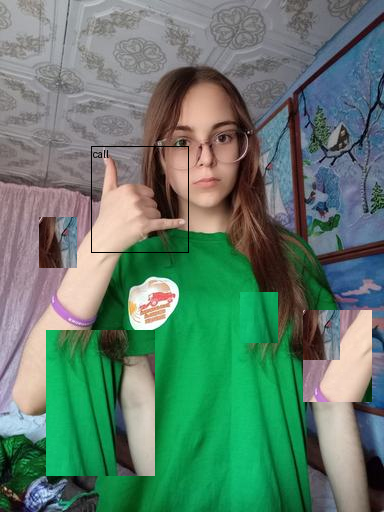

In [ ]:
# Create a RandomPatchCopy object
rand_patch_copy_tfm = RandomPatchCopy(pct=0.3, min_num=1, max_num=4)

# Feed sample image and targets through the image transform
augmented_img, augmented_targets = rand_patch_copy_tfm(sample_img, targets)
# Remove degenerate/invalid bounding boxes and their corresponding labels and masks.
sanitized_img, sanitized_targets = transforms.SanitizeBoundingBoxes()(augmented_img, augmented_targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(sanitized_img), 
    boxes=sanitized_targets['boxes'], 
    labels=[class_names[int(label.item())] for label in sanitized_targets['labels']], 
)

# Display the augmented image
tensor_to_pil(annotated_tensor)

In [ ]:
#| export
class RandomPixelCopy(transforms.Transform):
    """
    A torchvision V2 transform that copies data from a randomly selected set of pixels to another 
    randomly selected set of pixels of a image tensor.
    """
    def __init__(self,
                 min_pct=0.0025, # The minimum percentage of the tensor's pixels to be copied.
                 max_pct:float=0.1 # The maximum percentage of the tensor's pixels to be copied.
                ):
        
        super().__init__()
        self.min_pct = min_pct
        self.max_pct = max_pct

    def rand_pixel_copy(self, 
                        img_tensor:torch.Tensor, # The input image tensor.
                        pct:float # The percentage of the total number of pixels to be selected as the source and target sets of pixels.
                       ) -> torch.Tensor : # The modified input image tensor.
        """
        Copy data from a randomly selected set of pixels to another randomly selected set of pixels of a image tensor.
        """
        
        src_dim = img_tensor.dim()
        
        img_tensor = img_tensor.unsqueeze(0) if src_dim == 3 else img_tensor
        
        # Get the shape of the img_tensor
        b, c, h, w = img_tensor.shape
        
        # Calculate the number of pixels to be selected
        num_pixels = int(img_tensor[-1:].numel() * pct)
        
        # Select the source pixel indices
        source_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
        source_indices[:, 0] = source_indices[:, 0] // w
        source_indices[:, 1] = source_indices[:, 1] % w
        
        # Select the target pixel indices
        target_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
        target_indices[:, 0] = target_indices[:, 0] // w
        target_indices[:, 1] = target_indices[:, 1] % w
        
        # Get the indices of the channels
        c_indices = torch.arange(c).repeat(num_pixels, 1).t()
        
        # Copy the pixels
        source_pixels = img_tensor[:, c_indices, source_indices[:, 0], source_indices[:, 1]]
        img_tensor[:, c_indices, target_indices[:, 0], target_indices[:, 1]] = source_pixels
        
        return img_tensor.squeeze(0) if src_dim == 3 else img_tensor

    @singledispatchmethod
    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        """Default Behavior: Don't modify the input"""
        return inpt

    @_transform.register(torch.Tensor)
    @_transform.register(tv_tensors.Image)
    def _(self, inpt: Union[torch.Tensor, tv_tensors.Image], params: Dict[str, Any]) -> Any:
        """Apply the `rand_pixel_copy` method to the input tensor"""
        return self.rand_pixel_copy(inpt, max(self.min_pct, random.random() * self.max_pct))

    @_transform.register(Image.Image)
    def _(self, inpt: Image.Image, params: Dict[str, Any]) -> Any:
        """Convert the PIL Image to a torch.Tensor to apply the transform"""
        inpt_torch = transforms.PILToTensor()(inpt)
        return transforms.ToPILImage()(self._transform(inpt_torch, params))

    @_transform.register(BoundingBoxes)
    @_transform.register(Mask)
    def _(self, inpt: Union[BoundingBoxes, Mask], params: Dict[str, Any]) -> Any:
        """Don't modify image annotations"""
        return inpt

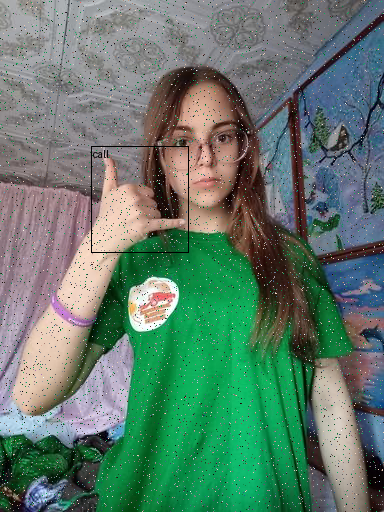

In [ ]:
# Create a RandomPixelCopy object
rand_pixel_copy_tfm = RandomPixelCopy(max_pct=0.05)

# Feed sample image and targets through the image transform
augmented_img, augmented_targets = rand_pixel_copy_tfm(sample_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(augmented_img), 
    boxes=augmented_targets['boxes'], 
    labels=[class_names[int(label.item())] for label in augmented_targets['labels']], 
)

# Display the augmented image
transforms.ToPILImage()(annotated_tensor)

In [ ]:
#| export
class CustomRandomAugment(torch.nn.Module):
    """
    A PyTorch Module for applying a random augmentation from a predefined set of augmentations
    to an image and its associated targets (e.g., bounding boxes, masks). This class is designed
    to work with torchvision transforms and supports augmentation of both images and their
    corresponding target data.
    """

    def __init__(self, 
                 num_bins:int=31, # The number of discrete levels for certain augmentations.
                 shear:int=18, # Maximum shear angle for the RandomAffine transform.
                 translate:float=0.25, # Maximum translation as a fraction of image dimensions for RandomAffine.
                 degrees:float=70.0, # Range of degrees for random rotations.
                 brightness:float=0.75, # Brightness adjustment factor.
                 hue:float=0.4, # Hue adjustment range.
                 saturation:float=0.99, # Saturation adjustment factor.
                 contrast:float=0.75, # Contrast adjustment factor.
                 sharpness:tuple=(0.0, 1.99), # Range for sharpness factor adjustments.
                 posterize:tuple=(2.0, 8.0), # Range for bits in posterization.
                 solarize:tuple=(1.0, 255.0), #  Threshold range for solarization.
                 auto_contrast:bool=True,
                 equalize:bool=True,
                ):
        """
        Initializes the CustomRandomAugment object with specific parameters for augmentations.
        """
        # Initialize the parent class (torch.nn.Module)
        super().__init__()

        # Number of bins for discretizing continuous parameters of augmentations
        self.num_bins = num_bins
        transformation_list = [
            transforms.Identity(),  # No-op, to sometimes leave images unchanged
        ]
        
        if shear is not None:
            transformation_list.append(transforms.RandomAffine(degrees=0.0, shear=shear))
        if translate is not None:
            transformation_list.append(transforms.RandomAffine(degrees=0.0, translate=(translate, translate)))
        if degrees is not None:
            transformation_list.append(transforms.RandomRotation(degrees=degrees))
        if brightness is not None:
            transformation_list.append(transforms.ColorJitter(brightness=brightness))
        if hue is not None:
            transformation_list.append(transforms.ColorJitter(hue=(-hue, hue)))
        if saturation is not None:
            transformation_list.append(transforms.ColorJitter(saturation=saturation))
        if contrast is not None:
            transformation_list.append(transforms.ColorJitter(contrast=contrast))

        if sharpness is not None:
            random_sharpness_tfms = [transforms.RandomAdjustSharpness(sharpness_factor=x, p=1.0) 
                                     for x in torch.linspace(*sharpness, num_bins)]
            transformation_list.append(transforms.RandomChoice(random_sharpness_tfms))
        if posterize is not None:
            random_posterize_tfms = [transforms.RandomPosterize(bits=x, p=1.0) 
                                     for x in torch.linspace(*posterize, num_bins).floor().int().numpy()]
            transformation_list.append(transforms.RandomChoice(random_posterize_tfms))
        if solarize is not None:
            random_solarize_tfms = [transforms.RandomSolarize(threshold=x, p=1.0) 
                                    for x in torch.linspace(*solarize, num_bins)]
            transformation_list.append(transforms.RandomChoice(random_solarize_tfms))

        if auto_contrast:
            transformation_list.append(transforms.RandomAutocontrast(p=1.0))  # Random autocontrast
        if equalize:
            transformation_list.append(transforms.RandomEqualize(p=1.0))  # Random equalize

        # Compose the transform
        self.transforms = transforms.RandomChoice(transformation_list)
    
    def forward(self, img, targets=None):
        """
        Applies a random augmentation to the input image and targets.

        Parameters:
            img (Tensor): The input image tensor.
            targets: The associated targets (e.g., bounding boxes, masks) with the image.

        Returns:
            A tuple containing the augmented image and targets.
        """
        # Apply the composed transformations to the image and targets
        return self.transforms(img, targets)

In [ ]:
#| hide
torch.manual_seed(0);

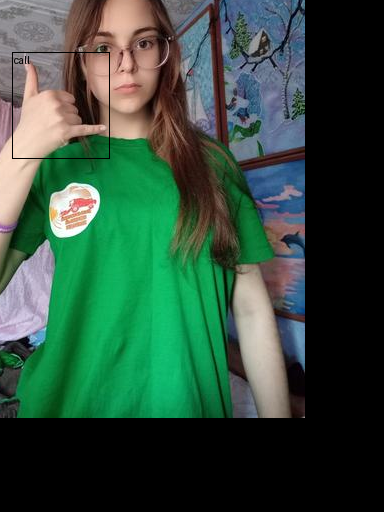

In [ ]:
# Create a RandomIoUCrop object
random_aug_tfm = CustomRandomAugment()

# Augment the image
augmented_img, augmented_targets = random_aug_tfm(sample_img, targets)
sanitized_img, sanitized_targets = transforms.SanitizeBoundingBoxes()(augmented_img, augmented_targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(sanitized_img), 
    boxes=sanitized_targets['boxes'], 
    labels=[class_names[int(label.item())] for label in sanitized_targets['labels']],
)

tensor_to_pil(annotated_tensor)

In [ ]:
#| export

import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F

from PIL import Image, ImageFilter, ImageChops


class AddLightGlare(transforms.Transform):
    """
    Adds a simple bloom/glare effect to images. All parameters can optionally be randomized from user-specified ranges.
    """

    def __init__(
        self,
        threshold_range=(180, 220),
        blur_radius_range=(5, 20),
        intensity_range=(0.5, 1.0),
    ):
        """
        Args:
            threshold_range (tuple): Range for the brightness threshold (0..255).
            blur_radius_range (tuple): Range for the Gaussian blur radius.
            intensity_range (tuple): Range for how strongly the glare is blended back.
        """
        super().__init__()
        self.threshold_range = threshold_range
        self.blur_radius_range = blur_radius_range
        self.intensity_range = intensity_range

    def _get_params(self, sample: Any) -> Dict[str, float]:
        """
        Randomly sample the parameters from the specified ranges.
        """
        threshold = random.uniform(*self.threshold_range)
        blur_radius = random.uniform(*self.blur_radius_range)
        intensity = random.uniform(*self.intensity_range)

        return {
            "threshold": threshold,
            "blur_radius": blur_radius,
            "intensity": intensity,
        }

    @singledispatchmethod
    def _transform(self, inpt, params):
        """
        Default behavior for unsupported input types: return unchanged.
        """
        return inpt

    @_transform.register(Image.Image)
    def _(self, inpt: Image.Image, params):
        """
        Handle PIL Images directly.
        """
        return self._apply_glare_pil(
            image=inpt,
            threshold=params["threshold"],
            blur_radius=params["blur_radius"],
            intensity=params["intensity"],
        )

    @_transform.register(torch.Tensor)
    @_transform.register(tv_tensors.Image)
    def _(self, inpt: torch.Tensor, params):
        """
        Handle torch.Tensor / tv_tensors.Image by converting to PIL,
        applying the glare, and converting back to the original type.
        """
        # Convert Tensor -> PIL
        pil_img = F.to_pil_image(inpt)

        # Apply glare
        glare_pil = self._apply_glare_pil(
            image=pil_img,
            threshold=params["threshold"],
            blur_radius=params["blur_radius"],
            intensity=params["intensity"],
        )

        # Convert back PIL -> Tensor
        out_tensor = transforms.PILToTensor()(glare_pil).float()

        # If the input was a tv_tensors.Image, wrap it back in the same class
        if isinstance(inpt, tv_tensors.Image):
            return tv_tensors.Image(out_tensor)
        else:
            return out_tensor

    @_transform.register(tv_tensors.BoundingBoxes)
    @_transform.register(tv_tensors.Mask)
    def _(self, inpt, params):
        """
        Do not modify bounding boxes or masks.
        """
        return inpt

    def _apply_glare_pil(
        self,
        image: Image.Image,
        threshold: float,
        blur_radius: float,
        intensity: float,
    ) -> Image.Image:
        """
        Applies a bloom/glare effect to a PIL image using the given parameters.
        Equivalent to your `add_light_glare` function, but with dynamic 
        parameter inputs.
        """
        # Convert image to RGB to ensure consistent channel operations
        image_rgb = image.convert("RGB")

        # 1. Create a brightness mask of the bright areas
        gray = image_rgb.convert("L")
        mask = gray.point(lambda p: 255 if p > threshold else 0, mode="L")

        # 2. Convert that mask to an image we can blur:
        #    multiply() with the mask isolates only the brightest areas
        glow_source = ImageChops.multiply(
            image_rgb,
            Image.merge("RGB", (mask, mask, mask))
        )

        # 3. Blur the isolated bright regions
        glow_blurred = glow_source.filter(ImageFilter.GaussianBlur(blur_radius))

        # 4. Screen-blend the blurred glow back onto the original
        glare_output = ImageChops.screen(image_rgb, glow_blurred)

        # 5. Blend glare_output with the original according to 'intensity'
        result = Image.blend(image_rgb, glare_output, intensity)

        return result

In [ ]:
#| export
class AddHaze(transforms.Transform):
    """
    Applies a haze/fog effect to images. Each parameter can be sampled from user-provided ranges. For fog_color, 
    we pick a single channel (0..255) and use it for (R, G, B).
    """

    def __init__(
        self, 
        blur_radius_range=(2, 6), 
        fog_intensity_range=(0.2, 0.5), 
        contrast_factor_range=(0.7, 0.9)
    ):
        """
        Args:
            blur_radius_range (tuple): Range from which to sample the Gaussian blur radius.
            fog_intensity_range (tuple): Range from which to sample the opacity of the fog overlay [0..1].
            contrast_factor_range (tuple): Range from which to sample the factor by which contrast is reduced.
        """
        super().__init__()
        self.blur_radius_range = blur_radius_range
        self.fog_intensity_range = fog_intensity_range
        self.contrast_factor_range = contrast_factor_range

    def _get_params(self, sample: Any) -> Dict[str, float]:
        """
        Randomly sample the parameters from specified ranges and 
        create a random fog color (grayscale).
        """
        blur_radius = random.uniform(*self.blur_radius_range)
        fog_intensity = random.uniform(*self.fog_intensity_range)
        contrast_factor = random.uniform(*self.contrast_factor_range)

        # For simplicity, let's pick one channel from 0..255 and apply to R, G, B
        fog_channel = random.randint(0, 255)
        fog_color = (fog_channel, fog_channel, fog_channel)

        return {
            "blur_radius": blur_radius,
            "fog_intensity": fog_intensity,
            "contrast_factor": contrast_factor,
            "fog_color": fog_color,
        }

    @singledispatchmethod
    def _transform(self, inpt, params):
        """
        Default behavior for unsupported input types: return unchanged.
        """
        return inpt

    @_transform.register(Image.Image)
    def _(self, inpt: Image.Image, params):
        """
        Handle PIL Images directly.
        """
        return self._apply_haze_pil(
            image=inpt, 
            blur_radius=params["blur_radius"],
            fog_intensity=params["fog_intensity"],
            contrast_factor=params["contrast_factor"],
            fog_color=params["fog_color"]
        )

    @_transform.register(torch.Tensor)
    @_transform.register(tv_tensors.Image)
    def _(self, inpt: torch.Tensor, params):
        """
        Handle torch.Tensor / tv_tensors.Image by converting to PIL,
        applying haze, and converting back to the original type.
        """
        # Convert Tensor -> PIL
        pil_img = TF.to_pil_image(inpt)

        # Apply haze
        hazy_pil = self._apply_haze_pil(
            image=pil_img,
            blur_radius=params["blur_radius"],
            fog_intensity=params["fog_intensity"],
            contrast_factor=params["contrast_factor"],
            fog_color=params["fog_color"],
        )

        # Convert back PIL -> Tensor
        out_tensor = transforms.PILToTensor()(hazy_pil).float()

        # If the input was a tv_tensors.Image, wrap it back in the same class
        if isinstance(inpt, tv_tensors.Image):
            return tv_tensors.Image(out_tensor)
        else:
            return out_tensor

    @_transform.register(tv_tensors.BoundingBoxes)
    @_transform.register(tv_tensors.Mask)
    def _(self, inpt, params):
        """
        Do not modify bounding boxes or masks.
        """
        return inpt

    def _apply_haze_pil(
        self, 
        image: Image.Image, 
        blur_radius: float, 
        fog_intensity: float, 
        contrast_factor: float, 
        fog_color: tuple
    ) -> Image.Image:
        """
        Apply the haze/fog logic directly to a PIL image.
        Equivalent to your `add_haze` function, but uses 
        the parameters from `_get_params`.
        """
        # 1. Convert to RGBA to ensure we can blend properly
        image_mode = image.mode
        image = image.convert("RGBA")

        # 2. Optionally reduce overall contrast to soften the image
        contrast_enhancer = ImageEnhance.Contrast(image)
        image_low_contrast = contrast_enhancer.enhance(contrast_factor)

        # 3. Create a blurred version of the image
        blurred = image_low_contrast.filter(ImageFilter.GaussianBlur(blur_radius))

        # 4. Blend original (low-contrast) with the blurred version
        #    Higher alpha in blend => more blur
        hazy = Image.blend(image_low_contrast, blurred, alpha=0.5)

        # 5. Add a translucent overlay (white or fog_color) to mimic “fog”
        fog_layer = Image.new("RGBA", hazy.size, fog_color + (0,))
        overlay_alpha = int(fog_intensity * 255)
        overlay = Image.new("RGBA", hazy.size, fog_color + (overlay_alpha,))
        fog_layer.paste(overlay, (0, 0))

        # 6. Composite the fog overlay on top of the hazy image
        final = Image.alpha_composite(hazy, fog_layer)

        return final.convert(image_mode)

In [ ]:
#| export
class RandomPerspectiveOpenCV:
    """
    Randomly applies a perspective transformation to an image (and its associated target data)
    using OpenCV.
    """
    def __init__(self, distortion_scale=0.5, p=0.5, fill=0, min_area=1.0, max_attempts=10):
        self.distortion_scale = distortion_scale
        self.p = p
        self.fill = fill
        # min_area is the minimum quadrilateral area we’ll accept
        # max_attempts is how many times we’ll try re-sampling offsets
        self.min_area = min_area
        self.max_attempts = max_attempts

    def __call__(self, image, target=None):
        # Randomly decide if we apply the transform
        if random.random() < self.p:
            image, target = self.apply_opencv_perspective(image, target)
        return image, target

    def apply_opencv_perspective(self, image, target):
        # Convert to NumPy
        np_image = self._to_numpy(image)
        H, W = np_image.shape[:2]

        # 1) Define source corners
        src_pts = np.float32([
            [0,     0    ],
            [W - 1, 0    ],
            [0,     H - 1],
            [W - 1, H - 1]
        ])

        # 2) Distortion scale -> random offset range
        max_offset = self.distortion_scale * min(H, W)

        # 3) Sample destination corners, ensuring area is not too small
        dst_pts = self._sample_valid_dst_pts(src_pts, max_offset, (W - 1, H - 1))

        # 4) Compute perspective transform matrix
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # 5) Warp image
        warped_image = cv2.warpPerspective(
            np_image, M, (W, H),
            borderValue=self.fill
        )

        # 6) Warp masks
        if target is not None:
            if "masks" in target:
                target["masks"] = self._warp_masks(target["masks"], M, (W, H))
            if "white_mask" in target:
                target["white_mask"] = self._warp_single_mask(
                    target["white_mask"], M, (W, H)
                )

        # 7) Warp bounding boxes
        if target is not None and "boxes" in target:
            target["boxes"] = self._warp_boxes(target["boxes"], M)

        # Convert back to appropriate type
        warped_pil = Image.fromarray(warped_image)
        if isinstance(image, TVImage):
            # Convert PIL -> torch -> TVImage
            warped_image = F.pil_to_tensor(warped_pil)
            warped_image = warped_image.as_subclass(TVImage)
        else:
            warped_image = warped_pil

        return warped_image, target

    def _sample_valid_dst_pts(self, src_pts, max_offset, max_xy):
        """
        Sample random offsets for each corner, ensuring the resulting
        quadrilateral has an area larger than self.min_area.
        """
        W_max, H_max = max_xy
        attempts = 0
        while True:
            # Copy source points
            dst_pts = src_pts.copy()
            # Randomly offset each corner
            for i in range(4):
                dx = np.random.uniform(-max_offset, max_offset)
                dy = np.random.uniform(-max_offset, max_offset)
                dst_pts[i, 0] = np.clip(dst_pts[i, 0] + dx, 0, W_max)
                dst_pts[i, 1] = np.clip(dst_pts[i, 1] + dy, 0, H_max)
            
            # Check area using the shoelace formula
            area = self._polygon_area(dst_pts)
            if area >= self.min_area:
                return dst_pts

            attempts += 1
            if attempts >= self.max_attempts:
                # Fallback: just return src_pts to avoid degeneracy
                return src_pts

    def _polygon_area(self, pts):
        """
        Compute the polygon area using the Shoelace formula.
        pts shape: [4, 2]
        """
        x = pts[:, 0]
        y = pts[:, 1]
        return 0.5 * abs(
            x[0]*y[1] + x[1]*y[2] + x[2]*y[3] + x[3]*y[0]
            - (y[0]*x[1] + y[1]*x[2] + y[2]*x[3] + y[3]*x[0])
        )

    # -----------------------------------------------------------
    # Helpers for warping masks, boxes, and converting images
    # -----------------------------------------------------------
    def _warp_masks(self, masks, M, size):
        if isinstance(masks, Mask):
            return self._warp_single_mask(masks, M, size)
        elif isinstance(masks, list):
            return [self._warp_single_mask(m, M, size) for m in masks]
        return masks

    def _warp_single_mask(self, mask, M, size):
        np_mask = np.array(mask.as_subclass(torch.Tensor).byte().squeeze(0))
        warped = cv2.warpPerspective(np_mask, M, size)
        # Convert back to bool
        warped_bool = (warped > 0)
        return Mask(torch.from_numpy(warped_bool).unsqueeze(0))

    def _warp_boxes(self, boxes: BoundingBoxes, M):
        # Convert boxes to xyxy
        xyxy_data = boxes.as_subclass(torch.Tensor)

        # Convert each box to corners: (x1, y1), (x2, y1), (x1, y2), (x2, y2)
        corners = self._boxes_to_corners(xyxy_data)  # [N,4,2]
        N = corners.shape[0]
        corners_reshaped = corners.view(-1, 2).numpy().astype(np.float32)

        corners_homo = np.expand_dims(corners_reshaped, 1)  # [N*4,1,2]
        warped_corners = cv2.perspectiveTransform(corners_homo, M)
        warped_corners = warped_corners.squeeze(1)  # [N*4, 2]
        warped_corners = warped_corners.reshape(N, 4, 2)

        x_min = warped_corners[:, :, 0].min(axis=1)
        y_min = warped_corners[:, :, 1].min(axis=1)
        x_max = warped_corners[:, :, 0].max(axis=1)
        y_max = warped_corners[:, :, 1].max(axis=1)

        warped_xyxy = torch.stack([
            torch.from_numpy(x_min),
            torch.from_numpy(y_min),
            torch.from_numpy(x_max),
            torch.from_numpy(y_max)
        ], dim=-1)

        # Rebuild bounding boxes
        warped_boxes = BoundingBoxes(
            warped_xyxy, format="xyxy", canvas_size=boxes.canvas_size
        )
        return warped_boxes

    def _boxes_to_corners(self, xyxy):
        x1, y1, x2, y2 = xyxy[:, 0], xyxy[:, 1], xyxy[:, 2], xyxy[:, 3]
        return torch.stack([
            torch.stack([x1, y1], dim=-1),  # top-left
            torch.stack([x2, y1], dim=-1),  # top-right
            torch.stack([x1, y2], dim=-1),  # bottom-left
            torch.stack([x2, y2], dim=-1),  # bottom-right
        ], dim=1)

    def _to_numpy(self, image):
        if isinstance(image, Image.Image):
            return np.array(image)
        elif isinstance(image, TVImage):
            return image.permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]
        elif isinstance(image, torch.Tensor):
            # If plain tensor [C,H,W]
            if image.ndim == 3:
                return image.permute(1, 2, 0).numpy()
            else:
                # If [H, W], just return
                return image.numpy()
        else:
            raise TypeError("Unsupported image type")


In [ ]:
import random
import numpy as np
import copy
from PIL import Image
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F
from torchvision.tv_tensors import BoundingBoxes, Mask, Image as TVImage

from cjm_torchvision_tfms.utils import find_largest_rectangle_coords

class RandomPerspectiveCrop(transforms.Transform):
    """
    Randomly applies a perspective transform to an image (and its target data),
    then crops the result based on a chosen strategy. This transform is useful
    for simulating complex distortions while ensuring the final image is neatly
    cropped to valid (non-distorted) areas.
    """

    def __init__(
        self,
        distortion_scale=0.5,
        p=0.5,
        fill=0,
        crop_strategy="all_nonzero"  # or "largest_rectangle"
    ):
        super().__init__()
        self.distortion_scale = distortion_scale
        self.p = p
        self.fill = fill
        self.crop_strategy = crop_strategy
        
        self._random_perspective = RandomPerspectiveOpenCV(
            distortion_scale=self.distortion_scale,
            p=self.p,
            fill=self.fill
        )

    def forward(self, image, target=None):
        # Track whether or not a target was passed in originally
        has_target = target is not None

        if not has_target:
            # Use an empty dict internally if no target was provided
            target = {}

        # 1) Create a white mask
        target["white_mask"] = self._create_white_mask(image)
    
        # 2) Apply random perspective
        image, target = self._random_perspective(image, target)

        # 2.5) Validate bounding boxes after warp
        if "boxes" in target and isinstance(target["boxes"], BoundingBoxes):
            h = image.height if isinstance(image, (TVImage, Image.Image)) else image.shape[-2]
            w = image.width  if isinstance(image, (TVImage, Image.Image)) else image.shape[-1]
            target["boxes"] = self._validate_and_clamp_boxes(
                target["boxes"], img_height=h, img_width=w
            )
    
        # 3) Crop (according to the chosen strategy)
        image, target = self._crop_to_white_mask(image, target)
    
        # 4) Remove 'white_mask'
        target.pop("white_mask", None)
    
        # Update boxes' canvas_size
        if "boxes" in target and isinstance(target["boxes"], BoundingBoxes):
            target["boxes"].canvas_size = (image.height, image.width)

        # If no target was originally passed, return only the image
        if not has_target:
            return image

        # Otherwise, return (image, target) as usual
        return image, target

    # -----------------------------------------------------
    # Helper: Create a white Mask of the same size as `image`
    # -----------------------------------------------------
    def _create_white_mask(self, image):
        if isinstance(image, Image.Image):
            w, h = image.size
        elif isinstance(image, TVImage):
            # tv_tensors.Image: shape [C, H, W]
            _, h, w = image.shape
        elif isinstance(image, torch.Tensor):
            # Plain tensor: shape could be [C, H, W] or [H, W]
            # We'll assume [C, H, W].
            _, h, w = image.shape
        else:
            raise TypeError("Unsupported image type for creating white mask")

        # Create a white (255) PIL mask
        pil_mask = Image.new("L", (w, h), color=255)

        # Convert to a bool Mask
        mask_tensor = transforms.PILToTensor()(pil_mask).bool()  # shape [1, H, W]
        return Mask(mask_tensor)

    # -----------------------------------------------------
    # Helper: Crop to the white mask
    # -----------------------------------------------------
    def _crop_to_white_mask(self, image, target):
        white_mask = target.get("white_mask", None)
        if white_mask is None:
            return image, target

        # Convert the tv_tensors.Mask -> a boolean tensor [H, W]
        wm_tensor = white_mask.as_subclass(torch.Tensor).squeeze(0)  # shape [H, W]

        # Decide how to find the region to crop
        if self.crop_strategy == "largest_rectangle":
            image, target = self._crop_largest_rectangle(image, target, wm_tensor)
        else:
            # Default: bounding box around all non-zero pixels
            image, target = self._crop_all_nonzero(image, target, wm_tensor)

        return image, target

    # -----------------------------------------------------
    # Strategy A: "all_nonzero" bounding box
    # -----------------------------------------------------
    def _crop_all_nonzero(self, image, target, wm_tensor):
        # wm_tensor is boolean, shape [H, W]
        rows = wm_tensor.any(dim=1)  # shape [H]
        cols = wm_tensor.any(dim=0)  # shape [W]

        if not rows.any() or not cols.any():
            return image, target  # No white area at all

        y_min = torch.where(rows)[0].min()
        y_max = torch.where(rows)[0].max()
        x_min = torch.where(cols)[0].min()
        x_max = torch.where(cols)[0].max()

        # Clamp to image boundaries
        y_min = torch.clamp(y_min, 0, image.height - 1)
        y_max = torch.clamp(y_max, 0, image.height - 1)
        x_min = torch.clamp(x_min, 0, image.width - 1)
        x_max = torch.clamp(x_max, 0, image.width - 1)

        if x_min >= x_max or y_min >= y_max:
            return image, target

        crop_width = (x_max - x_min + 1).item()
        crop_height = (y_max - y_min + 1).item()

        if crop_width <= 0 or crop_height <= 0:
            return image, target

        # Now do the crop
        image = F.crop(
            image,
            top=y_min.item(),
            left=x_min.item(),
            height=crop_height,
            width=crop_width
        )

        # Crop bboxes
        boxes = target.get("boxes", None)
        if isinstance(boxes, BoundingBoxes):
            target["boxes"] = F.crop(
                boxes,
                top=y_min.item(),
                left=x_min.item(),
                height=crop_height,
                width=crop_width
            )

        # Crop masks
        masks = target.get("masks", None)
        if isinstance(masks, Mask):
            target["masks"] = F.crop(
                masks,
                top=y_min.item(),
                left=x_min.item(),
                height=crop_height,
                width=crop_width
            )
        elif isinstance(masks, list):
            new_list = []
            for m in masks:
                new_list.append(
                    F.crop(m, top=y_min.item(), left=x_min.item(),
                           height=crop_height, width=crop_width)
                )
            target["masks"] = new_list

        return image, target

    # -----------------------------------------------------
    # Strategy B: "largest_rectangle" inside the white mask
    # -----------------------------------------------------
    def _crop_largest_rectangle(self, image, target, wm_tensor):
        """
        Uses find_largest_rectangle_coords(...) approach to find
        the largest rectangle of True pixels in wm_tensor, then crops
        image/boxes/masks to that rectangle.
        """
        # Convert torch tensor -> numpy array (bool)
        white_mask_np = wm_tensor.cpu().numpy()  # shape [H, W], dtype=bool

        # 1) Find row_slice, col_slice
        row_slice, col_slice = find_largest_rectangle_coords(white_mask_np)
        # row_slice and col_slice are Python slice objects

        # If the largest rectangle is effectively zero-sized, skip
        if row_slice.stop <= row_slice.start or col_slice.stop <= col_slice.start:
            return image, target

        # 2) Convert slices to top, left, height, width
        top = row_slice.start
        left = col_slice.start
        bottom = row_slice.stop
        right = col_slice.stop

        crop_height = bottom - top
        crop_width = right - left

        # Basic sanity
        if crop_height <= 0 or crop_width <= 0:
            return image, target

        # 3) Crop the image
        image = F.crop(
            image,
            top=top,
            left=left,
            height=crop_height,
            width=crop_width
        )

        # 4) Crop bounding boxes
        boxes = target.get("boxes", None)
        if isinstance(boxes, BoundingBoxes):
            target["boxes"] = F.crop(
                boxes,
                top=top,
                left=left,
                height=crop_height,
                width=crop_width
            )

        # 5) Crop masks
        masks = target.get("masks", None)
        if isinstance(masks, Mask):
            target["masks"] = F.crop(
                masks,
                top=top,
                left=left,
                height=crop_height,
                width=crop_width
            )
        elif isinstance(masks, list):
            new_list = []
            for m in masks:
                new_list.append(
                    F.crop(
                        m,
                        top=top,
                        left=left,
                        height=crop_height,
                        width=crop_width
                    )
                )
            target["masks"] = new_list

        return image, target

    # -----------------------------------------------------
    # Helper: Validate/clamp bounding boxes
    # -----------------------------------------------------
    def _validate_and_clamp_boxes(self, boxes: BoundingBoxes, img_height: int, img_width: int):
        x1, y1, x2, y2 = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3]
        x1_clamped = x1.clamp(min=0, max=img_width - 1)
        y1_clamped = y1.clamp(min=0, max=img_height - 1)
        x2_clamped = x2.clamp(min=0, max=img_width - 1)
        y2_clamped = y2.clamp(min=0, max=img_height - 1)
    
        new_boxes_xyxy = torch.stack([x1_clamped, y1_clamped, x2_clamped, y2_clamped], dim=-1)
        updated_boxes = BoundingBoxes(new_boxes_xyxy, format="xyxy", canvas_size=(img_height, img_width))
        return updated_boxes

In [ ]:
#| export

class RandomRotationCrop(transforms.Transform):
    """
    Randomly applies a rotation to an image (and its target data),
    then crops the result based on a chosen strategy. Similar to
    RandomPerspectiveCrop, but wraps RandomRotation instead.
    """

    def __init__(
        self,
        degrees,
        p=0.5,
        fill=0,
        expand=False,
        center=None,
        crop_strategy="all_nonzero",  # or "largest_rectangle"
    ):
        """
        Args:
            degrees: Range of degrees (min, max) for rotation.
            p (float): Probability of applying the rotation.
            fill (int or tuple): Pixel fill value for the area outside the rotated image.
            expand (bool): If True, expand the output image to hold the entire rotated image.
            center (tuple): Optional center of rotation.
            crop_strategy (str): "all_nonzero" or "largest_rectangle"
        """
        super().__init__()
        self.degrees = degrees
        self.p = p
        self.fill = fill
        self.expand = expand
        self.center = center
        self.crop_strategy = crop_strategy


    def forward(self, image, target=None):
        # Flag to detect if a target was originally provided
        has_target = target is not None

        if not has_target:
            # Use an empty dict internally if no target was provided
            target = {}

        # 1) Create a white mask for tracking the "valid" region after rotation
        target["white_mask"] = self._create_white_mask(image)

        # 2) Decide whether to apply the rotation
        if random.random() < self.p:
            # Choose random angle
            angle = self._get_random_angle(self.degrees)

            # Rotate image
            image = F.rotate(
                image,
                angle=angle,
                expand=self.expand,
                center=self.center,
                fill=self.fill
            )

            # Rotate bounding boxes
            if "boxes" in target and isinstance(target["boxes"], BoundingBoxes):
                boxes = target["boxes"]
                boxes = F.rotate(
                    boxes,
                    angle=angle,
                    expand=self.expand,
                    center=self.center,
                    # fill is not used by bounding boxes, so we omit it
                )
                # Because rotation can move boxes out of bounds, clamp them
                h = image.height if isinstance(image, (TVImage, Image.Image)) else image.shape[-2]
                w = image.width  if isinstance(image, (TVImage, Image.Image)) else image.shape[-1]
                boxes = self._validate_and_clamp_boxes(boxes, img_height=h, img_width=w)
                target["boxes"] = boxes

            # Rotate masks
            if "masks" in target:
                masks = target["masks"]
                if isinstance(masks, Mask):
                    masks = F.rotate(
                        masks,
                        angle=angle,
                        expand=self.expand,
                        center=self.center,
                        fill=False,  # For boolean mask, fill with False
                    )
                elif isinstance(masks, list):
                    rotated_list = []
                    for m in masks:
                        rotated_list.append(
                            F.rotate(
                                m,
                                angle=angle,
                                expand=self.expand,
                                center=self.center,
                                fill=False,
                            )
                        )
                    masks = rotated_list
                target["masks"] = masks

            # Rotate the "white_mask"
            wm = target["white_mask"]
            wm = F.rotate(
                wm,
                angle=angle,
                expand=self.expand,
                center=self.center,
                fill=False,  # fill with False for the mask
            )
            target["white_mask"] = wm

        # 3) Crop (according to the chosen strategy)
        image, target = self._crop_to_white_mask(image, target)

        # 4) Remove 'white_mask'
        target.pop("white_mask", None)

        # 5) Update boxes' canvas_size (if boxes exist)
        if "boxes" in target and isinstance(target["boxes"], BoundingBoxes):
            target["boxes"].canvas_size = (image.height, image.width)

        # If no target was originally passed, return only the image
        if not has_target:
            return image

        # Otherwise, return (image, target)
        return image, target

    # -----------------------------------------------------
    # Helper: Generate a random angle from degrees tuple/int
    # -----------------------------------------------------
    def _get_random_angle(self, degrees):
        """If degrees is a (min, max) tuple, sample uniformly;
           if it's a single float/int, sample from [-degrees, degrees]."""
        if isinstance(degrees, (list, tuple)):
            assert len(degrees) == 2, "degrees should be (min, max)"
            return random.uniform(degrees[0], degrees[1])
        else:
            return random.uniform(-abs(degrees), abs(degrees))

    # -----------------------------------------------------
    # Helper: Create a white Mask of the same size as `image`
    # -----------------------------------------------------
    def _create_white_mask(self, image):
        if isinstance(image, Image.Image):
            w, h = image.size
        elif isinstance(image, TVImage):
            # tv_tensors.Image: shape [C, H, W]
            _, h, w = image.shape
        elif isinstance(image, torch.Tensor):
            # Plain tensor: shape could be [C, H, W] or [H, W]
            # We'll assume [C, H, W].
            _, h, w = image.shape
        else:
            raise TypeError("Unsupported image type for creating white mask")

        # Create a white (255) PIL mask
        pil_mask = Image.new("L", (w, h), color=255)

        # Convert to a bool Mask
        mask_tensor = transforms.PILToTensor()(pil_mask).bool()  # shape [1, H, W]
        return Mask(mask_tensor)

    # -----------------------------------------------------
    # Helper: Crop to the white mask
    # -----------------------------------------------------
    def _crop_to_white_mask(self, image, target):
        white_mask = target.get("white_mask", None)
        if white_mask is None:
            return image, target

        # Convert tv_tensors.Mask -> a boolean tensor [H, W]
        wm_tensor = white_mask.as_subclass(torch.Tensor).squeeze(0)  # shape [H, W]

        # Decide how to find the region to crop
        if self.crop_strategy == "largest_rectangle":
            image, target = self._crop_largest_rectangle(image, target, wm_tensor)
        else:
            # Default: bounding box around all non-zero pixels
            image, target = self._crop_all_nonzero(image, target, wm_tensor)

        return image, target

    # -----------------------------------------------------
    # Strategy A: "all_nonzero" bounding box
    # -----------------------------------------------------
    def _crop_all_nonzero(self, image, target, wm_tensor):
        # wm_tensor is boolean, shape [H, W]
        rows = wm_tensor.any(dim=1)  # shape [H]
        cols = wm_tensor.any(dim=0)  # shape [W]

        if not rows.any() or not cols.any():
            return image, target  # No white area at all

        y_min = torch.where(rows)[0].min()
        y_max = torch.where(rows)[0].max()
        x_min = torch.where(cols)[0].min()
        x_max = torch.where(cols)[0].max()

        # Clamp to image boundaries
        y_min = torch.clamp(y_min, 0, image.height - 1)
        y_max = torch.clamp(y_max, 0, image.height - 1)
        x_min = torch.clamp(x_min, 0, image.width - 1)
        x_max = torch.clamp(x_max, 0, image.width - 1)

        if x_min >= x_max or y_min >= y_max:
            return image, target

        crop_width = (x_max - x_min + 1).item()
        crop_height = (y_max - y_min + 1).item()

        if crop_width <= 0 or crop_height <= 0:
            return image, target

        # Now do the crop
        image = F.crop(
            image,
            top=y_min.item(),
            left=x_min.item(),
            height=crop_height,
            width=crop_width
        )

        # Crop bboxes
        boxes = target.get("boxes", None)
        if isinstance(boxes, BoundingBoxes):
            target["boxes"] = F.crop(
                boxes,
                top=y_min.item(),
                left=x_min.item(),
                height=crop_height,
                width=crop_width
            )

        # Crop masks
        masks = target.get("masks", None)
        if isinstance(masks, Mask):
            target["masks"] = F.crop(
                masks,
                top=y_min.item(),
                left=x_min.item(),
                height=crop_height,
                width=crop_width
            )
        elif isinstance(masks, list):
            new_list = []
            for m in masks:
                new_list.append(
                    F.crop(m, top=y_min.item(), left=x_min.item(),
                           height=crop_height, width=crop_width)
                )
            target["masks"] = new_list

        return image, target

    # -----------------------------------------------------
    # Strategy B: "largest_rectangle" inside the white mask
    # -----------------------------------------------------
    def _crop_largest_rectangle(self, image, target, wm_tensor):
        """
        Uses find_largest_rectangle_coords(...) to find
        the largest rectangle of True pixels in wm_tensor, then crops
        image/boxes/masks to that rectangle.
        """
        # Convert torch tensor -> numpy array (bool)
        white_mask_np = wm_tensor.cpu().numpy()  # shape [H, W], dtype=bool

        # 1) Find row_slice, col_slice
        row_slice, col_slice = find_largest_rectangle_coords(white_mask_np)
        # row_slice and col_slice are Python slice objects

        # If the largest rectangle is effectively zero-sized, skip
        if row_slice.stop <= row_slice.start or col_slice.stop <= col_slice.start:
            return image, target

        # 2) Convert slices to top, left, height, width
        top = row_slice.start
        left = col_slice.start
        bottom = row_slice.stop
        right = col_slice.stop

        crop_height = bottom - top
        crop_width = right - left

        # Basic sanity
        if crop_height <= 0 or crop_width <= 0:
            return image, target

        # 3) Crop the image
        image = F.crop(
            image,
            top=top,
            left=left,
            height=crop_height,
            width=crop_width
        )

        # 4) Crop bounding boxes
        boxes = target.get("boxes", None)
        if isinstance(boxes, BoundingBoxes):
            target["boxes"] = F.crop(
                boxes,
                top=top,
                left=left,
                height=crop_height,
                width=crop_width
            )

        # 5) Crop masks
        masks = target.get("masks", None)
        if isinstance(masks, Mask):
            target["masks"] = F.crop(
                masks,
                top=top,
                left=left,
                height=crop_height,
                width=crop_width
            )
        elif isinstance(masks, list):
            new_list = []
            for m in masks:
                new_list.append(
                    F.crop(
                        m,
                        top=top,
                        left=left,
                        height=crop_height,
                        width=crop_width
                    )
                )
            target["masks"] = new_list

        return image, target

    # -----------------------------------------------------
    # Helper: Validate/clamp bounding boxes
    # -----------------------------------------------------
    def _validate_and_clamp_boxes(self, boxes: BoundingBoxes, img_height: int, img_width: int):
        x1, y1, x2, y2 = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3]
        x1_clamped = x1.clamp(min=0, max=img_width - 1)
        y1_clamped = y1.clamp(min=0, max=img_height - 1)
        x2_clamped = x2.clamp(min=0, max=img_width - 1)
        y2_clamped = y2.clamp(min=0, max=img_height - 1)
    
        new_boxes_xyxy = torch.stack([x1_clamped, y1_clamped, x2_clamped, y2_clamped], dim=-1)
        updated_boxes = BoundingBoxes(new_boxes_xyxy, format="xyxy", canvas_size=(img_height, img_width))
        return updated_boxes

In [ ]:
#| export
class RandomOneDimResize(transforms.Transform):
    """
    A PyTorch Transform that randomly scales only one dimension (height or width)
    of an image by a random factor within a specified range, while keeping the
    other dimension unchanged.
    """
    
    def __init__(
        self,
        scale_range=(0.5, 1.5),
        interpolation=InterpolationMode.BILINEAR,
        antialias=True
    ):
        """
        Initializes the transform with the desired scale range, interpolation
        mode, and an antialiasing flag.

        Args:
            scale_range (tuple of float): The minimum and maximum scale factors
                to sample from. For example, (0.5, 1.5) means the chosen dimension
                will be scaled between 50% and 150% of its original size.
            interpolation (InterpolationMode): Interpolation mode used for resizing.
            antialias (bool): Whether to use anti-aliasing when resizing.
        """
        super().__init__()
        self.scale_range = scale_range
        self.interpolation = interpolation
        self.antialias = antialias
        self.scale = None
        self.side = None


    def forward(self, 
                *inputs: Any # The inputs to the forward method.
               ) -> Any: # The result of the superclass forward method.
        """
        
        """
        # Sample a random scale factor in the provided range
        self.scale = random.uniform(*self.scale_range)
        self.side = random.random()
        return super().forward(*inputs)
        
    def _transform(
        self,
        inpt: torch.Tensor,
        params: dict
    ) -> torch.Tensor:
        """
        Apply the RandomOneDimResize transformation on the input image tensor.

        Args:
            inpt (torch.Tensor): The input image tensor to be transformed.
            params (dict): A dictionary of parameters (not used here).

        Returns:
            torch.Tensor: The transformed (resized) image tensor.
        """
        # Copy the input to a local variable (optional but often clearer)
        x = inpt
        
        # Get the (height, width) of the image tensor
        h, w = TF.get_size(x)  # returns (height, width)
        
        # Randomly choose which dimension (height or width) to scale
        if self.side < 0.5:
            # Scale the height, keep the width unchanged
            new_h = int(h * self.scale)
            new_w = w
        else:
            # Scale the width, keep the height unchanged
            new_h = h
            new_w = int(w * self.scale)
        
        # Make sure we don't get 0 for any dimension
        new_h = max(new_h, 1)
        new_w = max(new_w, 1)
        
        # Resize the image using v2 functional API
        x = TF.resize(
            x,
            size=(new_h, new_w),
            interpolation=self.interpolation,
            antialias=self.antialias
        )
        
        return x

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()